# Necessary Libraries


In [1]:
import pandas as pd
import re
import string
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import io
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
from google.colab import files
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, GRU, Embedding, Dropout, Activation
from keras.layers import Bidirectional
from keras.models import Model

# from  matplotlib import pyplot as plt
from keras.utils.vis_utils import plot_model
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score
from sklearn.metrics import roc_curve, auc,accuracy_score
# Time and counters
from time import perf_counter

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


# Reading DataSet

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#uploaded = files.upload()

In [3]:
#uploaded = files.upload()
dataPath   = "drive/MyDrive/Mahboob/Dataset/" 
heatmaps   = "drive/MyDrive/Mahboob/Heatmaps/"
Visuals    = "drive/MyDrive/Mahboob/Visuals/"
Comparison = "drive/MyDrive/Mahboob/Comparison/"
Model      = "drive/MyDrive/Mahboob/Models/"

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])


def ROC_AUC(y_test, y_pred, fname):
    # evluate true positive rate and false positive rate using sklearn builtin function
    lr_fpr, lr_tpr, _ = roc_curve(y_test, y_pred)
    # find area under curve score
    lr_auc = auc(lr_fpr, lr_tpr)

    # display auc score
    print("AUC:", lr_auc)
    # plot linear line with no learning
    plt.plot([0, 1], [0, 1], 'k--')
    # plot tpr and fpr ratio
    plt.plot(lr_fpr, lr_tpr, marker='.', label='lr (auc = %0.3f)' % lr_auc)
    # assign labels
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Receiver Operating Characterisics')
    plt.legend(loc='lower right')
    plt.savefig(f"{Visuals}{fname}")
    # plt.savefig(f"{fname}.jpeg")
    return lr_auc

def get_Metrics(y_test, y_pred, average="macro"):
    
    lr_fpr, lr_tpr, _ = roc_curve(y_test, y_pred)
    # find area under curve score
    lr_auc = auc(lr_fpr, lr_tpr)
    precision = precision_score(y_test, y_pred, average = average)
    recall = recall_score(y_test, y_pred, average = average)
    f1_score_ = f1_score(y_test, y_pred, average = average)
    accuracy = accuracy_score(y_test, y_pred)
    #print(f"precision : {precision} recall : {recall} f1_score : {f1_score_} accuracy : {accuracy}")
    return precision, recall, f1_score_, accuracy, lr_auc


In [4]:
data = pd.read_csv(f"{dataPath}spam(madeof).csv")
data.head()

,v1,v2
0,ham,Subject: enron methanol ; meter # : 988291\nth...
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see..."
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar..."
3,spam,"Subject: photoshop , windows , office . cheap ..."
4,ham,Subject: re : indian springs\r\nthis deal is t...


In [5]:
data["spam"] = data.v1
data["text"] = data.v2

# Splitting data

In [6]:
emails_train, emails_test, target_train, target_test = train_test_split(data.text, data.spam, test_size = 0.2) 

In [7]:
data.info

<bound method DataFrame.info of         v1  ...                                               text
0      ham  ...  Subject: enron methanol ; meter # : 988291\nth...
1      ham  ...  Subject: hpl nom for january 9 , 2001\r\n( see...
2      ham  ...  Subject: neon retreat\r\nho ho ho , we ' re ar...
3     spam  ...  Subject: photoshop , windows , office . cheap ...
4      ham  ...  Subject: re : indian springs\r\nthis deal is t...
...    ...  ...                                                ...
5166   ham  ...  Subject: put the 10 on the ft\r\nthe transport...
5167   ham  ...  Subject: 3 / 4 / 2000 and following noms\r\nhp...
5168   ham  ...  Subject: calpine daily gas nomination\r\n>\r\n...
5169   ham  ...  Subject: industrial worksheets for august 2000...
5170  spam  ...  Subject: important online banking alert\r\ndea...

[5171 rows x 4 columns]>

In [8]:
emails_train.shape

(4136,)

# Preprocessing

In [9]:
def remove_hyperlink(word):
    return  re.sub(r'http\S+', '', word)

def to_lower(word):
    result = word.lower()
    return result

def remove_number(word):
    result = re.sub(r'\d+', '', word)
    return result

def remove_punctuation(word):
    result = word.translate(str.maketrans(dict.fromkeys(string.punctuation)))
    return result

def remove_whitespace(word):
    result = word.strip()
    return result

def replace_newline(word):
    return word.replace('\n','')



def clean_up_pipeline(sentence):
    cleaning_utils = [remove_hyperlink,
                      replace_newline,
                      to_lower,
                      remove_number,
                      remove_punctuation,
                      remove_whitespace]
    for o in cleaning_utils:
        sentence = o(sentence)
    return sentence

x_train = [clean_up_pipeline(o) for o in emails_train]
x_test = [clean_up_pipeline(o) for o in emails_test]

#x_train[0]

In [10]:
le = LabelEncoder()
train_y = le.fit_transform(target_train.values)
test_y = le.transform(target_test.values)

In [11]:
train_y


array([0, 1, 0, ..., 1, 0, 1])

# Tokenize

In [12]:
## some config values 
embed_size = 100 # how big is each word vector
max_feature = 50000 # how many unique words to use (i.e num rows in embedding vector)
max_len = 2000 # max number of words in a question to use

In [13]:
tokenizer = Tokenizer(num_words=max_feature)

tokenizer.fit_on_texts(x_train)

x_train_features = np.array(tokenizer.texts_to_sequences(x_train))
x_test_features = np.array(tokenizer.texts_to_sequences(x_test))

#x_train_features[0]

# Padding

In [14]:
x_train_features = pad_sequences(x_train_features,maxlen=max_len)
x_test_features = pad_sequences(x_test_features,maxlen=max_len)
x_train_features[0]

array([  0,   0,   0, ...,   8, 748,  87], dtype=int32)

# Model

In [15]:
embedding_vecor_length = 32

#**LSTM** 

In [16]:
# LSTM
model = tf.keras.Sequential()
model.add(Embedding(max_feature, embedding_vecor_length, input_length=max_len))
model.add(tf.keras.layers.LSTM(64))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2000, 32)          1600000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 1,625,889
Trainable params: 1,625,889
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
# LSTM
start = perf_counter()
history = model.fit(x_train_features, train_y, batch_size=512, epochs=15, validation_split=0.2)
duration_lstm = perf_counter() - start
duration_lstm = round(duration_lstm,2)
lstm_history = history 

Epoch 1/15
7/7 [==============================] - 7s 264ms/step - loss: 0.6691 - accuracy: 0.6681 - val_loss: 0.6315 - val_accuracy: 0.7162
Epoch 2/15
7/7 [==============================] - 1s 184ms/step - loss: 0.5723 - accuracy: 0.7101 - val_loss: 0.5625 - val_accuracy: 0.7162
Epoch 3/15
7/7 [==============================] - 1s 184ms/step - loss: 0.4867 - accuracy: 0.7192 - val_loss: 0.3849 - val_accuracy: 0.7307
Epoch 4/15
7/7 [==============================] - 1s 184ms/step - loss: 0.3348 - accuracy: 0.8226 - val_loss: 0.3101 - val_accuracy: 0.8575
Epoch 5/15
7/7 [==============================] - 1s 183ms/step - loss: 0.2612 - accuracy: 0.9359 - val_loss: 0.2398 - val_accuracy: 0.9022
Epoch 6/15
7/7 [==============================] - 1s 184ms/step - loss: 0.1967 - accuracy: 0.9710 - val_loss: 0.2734 - val_accuracy: 0.9626
Epoch 7/15
7/7 [==============================] - 1s 184ms/step - loss: 0.1587 - accuracy: 0.9906 - val_loss: 0.1374 - val_accuracy: 0.9746
Epoch 8/15
7/7 [====

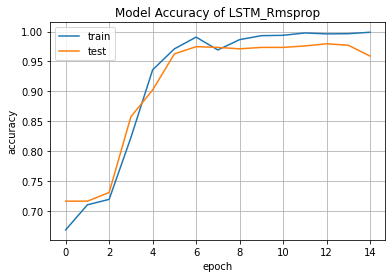

<Figure size 432x288 with 0 Axes>

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy of LSTM_Rmsprop')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()
plt.savefig(f"{Visuals}LSTM-rms-acc-loss.jpeg")

#Confusion Matrix

In [19]:
y_predict  = [1 if o>0.5 else 0 for o in model.predict(x_test_features)]

In [20]:
cf_matrix =confusion_matrix(test_y,y_predict)

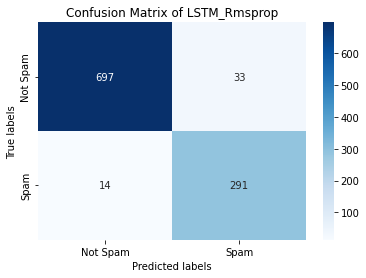

In [21]:
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt='') #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix of LSTM_Rmsprop')
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']) 
ax.yaxis.set_ticklabels(['Not Spam', 'Spam'])
plt.savefig(f"{heatmaps}LSTM-rms-heatmap.jpeg")

In [22]:
tn, fp, fn, tp = confusion_matrix(test_y,y_predict).ravel()

In [23]:
print("Precision: {:.2f}%".format(100 * precision_score(test_y, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(test_y, y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(test_y,y_predict)))

Precision: 89.81%
Recall: 95.41%
F1 Score: 92.53%


In [24]:
f1_score(test_y,y_predict)

0.9252782193958665

AUC: 0.9544464406018416


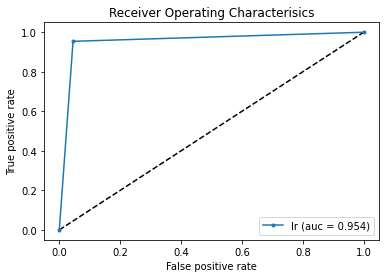

In [25]:
#AUC
auc_lstm = ROC_AUC(test_y, y_predict, "LSTM_rms_AUC.jpeg")

In [26]:
lstm = {
    "train-acc" : history.history["accuracy"][len(history.history["accuracy"])-1],
    "test-acc" : accuracy_score(test_y,y_predict),
    "precision" : precision_score(test_y, y_predict),
    "recall" : recall_score(test_y, y_predict),
    "f1-score" : f1_score(test_y,y_predict),
    "AUC" : auc_lstm,
    "duration" : duration_lstm

}

In [27]:
!ls
model.save("drive/MyDrive/Mahboob/Models/LSTM_rms.h5")

drive  sample_data


In [28]:
lstm

{'AUC': 0.9544464406018416,
 'duration': 43.25,
 'f1-score': 0.9252782193958665,
 'precision': 0.8981481481481481,
 'recall': 0.9540983606557377,
 'test-acc': 0.9545893719806763,
 'train-acc': 0.9987908005714417}

#**Bi-LSTM**

In [29]:
# Bilstm
model = tf.keras.Sequential()
model.add(Embedding(max_feature, embedding_vecor_length, input_length=max_len))
model.add(Bidirectional(tf.keras.layers.LSTM(64)))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2000, 32)          1600000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               49664     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 1,651,745
Trainable params: 1,651,745
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
# BiLSTM
start = perf_counter()
history = model.fit(x_train_features, train_y, batch_size=512, epochs=20, validation_split=0.2)
duration_bi_lstm = perf_counter() - start
duration_bi_lstm = round(duration_bi_lstm,2)
bi_lstm_history = history 

Epoch 1/20
7/7 [==============================] - 7s 476ms/step - loss: 0.6465 - accuracy: 0.6578 - val_loss: 0.5639 - val_accuracy: 0.7162
Epoch 2/20
7/7 [==============================] - 2s 341ms/step - loss: 0.6080 - accuracy: 0.7104 - val_loss: 0.4848 - val_accuracy: 0.7162
Epoch 3/20
7/7 [==============================] - 2s 344ms/step - loss: 0.4497 - accuracy: 0.7391 - val_loss: 0.4607 - val_accuracy: 0.8442
Epoch 4/20
7/7 [==============================] - 2s 343ms/step - loss: 0.3591 - accuracy: 0.8909 - val_loss: 0.2587 - val_accuracy: 0.9287
Epoch 5/20
7/7 [==============================] - 2s 339ms/step - loss: 0.2759 - accuracy: 0.9123 - val_loss: 0.2408 - val_accuracy: 0.9601
Epoch 6/20
7/7 [==============================] - 2s 344ms/step - loss: 0.1689 - accuracy: 0.9813 - val_loss: 0.1476 - val_accuracy: 0.9686
Epoch 7/20
7/7 [==============================] - 2s 343ms/step - loss: 0.0947 - accuracy: 0.9852 - val_loss: 0.1020 - val_accuracy: 0.9722
Epoch 8/20
7/7 [====

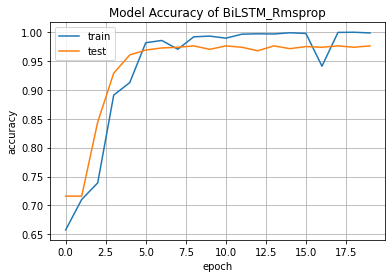

<Figure size 432x288 with 0 Axes>

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy of BiLSTM_Rmsprop')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()
plt.savefig(f"{Visuals}Bi-LSTM-rms-acc-loss.jpeg")

#Confusion Matrix BiLSTM


In [32]:
y_predict  = [1 if o>0.5 else 0 for o in model.predict(x_test_features)]

In [33]:
cf_matrix =confusion_matrix(test_y,y_predict)

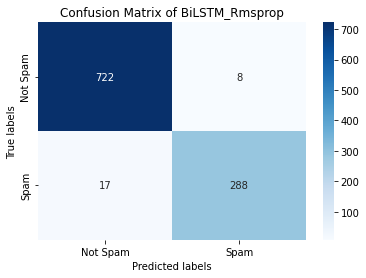

In [34]:
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt='') #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix of BiLSTM_Rmsprop') 
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']) 
ax.yaxis.set_ticklabels(['Not Spam', 'Spam'])
plt.savefig(f"{heatmaps}Bi-LSTM-rms-heatmap.jpeg")

In [35]:
tn, fp, fn, tp = confusion_matrix(test_y,y_predict).ravel()

In [36]:
print("Precision: {:.2f}%".format(100 * precision_score(test_y, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(test_y, y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(test_y,y_predict)))

Precision: 97.30%
Recall: 94.43%
F1 Score: 95.84%


In [37]:
f1_score(test_y,y_predict)

0.9584026622296173

AUC: 0.9666516954861891


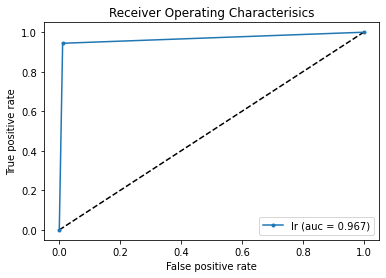

In [38]:
#AUC
auc_bi_lstm = ROC_AUC(test_y, y_predict, "Bi-LSTM-rms_AUC.jpeg")

In [39]:
Bi_lstm = {
    "train-acc" : history.history["accuracy"][len(history.history["accuracy"])-1],
    "test-acc" : accuracy_score(test_y,y_predict),
    "precision" : precision_score(test_y, y_predict),
    "recall" : recall_score(test_y, y_predict),
    "f1-score" : f1_score(test_y,y_predict),
    "AUC" : auc_bi_lstm,
    "duration" : duration_bi_lstm

}

In [40]:
!ls
model.save("drive/MyDrive/Mahboob/Models/Bi_LSTM-rms.h5")

drive  sample_data


In [41]:
Bi_lstm

{'AUC': 0.9666516954861891,
 'duration': 85.54,
 'f1-score': 0.9584026622296173,
 'precision': 0.972972972972973,
 'recall': 0.9442622950819672,
 'test-acc': 0.9758454106280193,
 'train-acc': 0.9981862306594849}

#**GRU**

In [42]:
#GRU
model = tf.keras.Sequential()
model.add(Embedding(max_feature, embedding_vecor_length, input_length=max_len))
# model.add(GRU(units=64, dropout=0.1,recurrent_dropout=0.1))
model.add(tf.keras.layers.GRU(64))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print(model.summary())


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 2000, 32)          1600000   
_________________________________________________________________
gru (GRU)                    (None, 64)                18816     
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 1,619,873
Trainable params: 1,619,873
Non-trainable params: 0
_________________________________________________________________
None


In [43]:
# GRU
start = perf_counter()
history = model.fit(x_train_features, train_y, batch_size=512, epochs=15, validation_split=0.2)
duration_gru = perf_counter() - start
duration_gru = round(duration_gru,2)
gru_history = history 

Epoch 1/15
7/7 [==============================] - 4s 257ms/step - loss: 0.6572 - accuracy: 0.6877 - val_loss: 0.5743 - val_accuracy: 0.7162
Epoch 2/15
7/7 [==============================] - 1s 187ms/step - loss: 0.5208 - accuracy: 0.7122 - val_loss: 0.4644 - val_accuracy: 0.7862
Epoch 3/15
7/7 [==============================] - 1s 188ms/step - loss: 0.3994 - accuracy: 0.8050 - val_loss: 0.3507 - val_accuracy: 0.8043
Epoch 4/15
7/7 [==============================] - 1s 187ms/step - loss: 0.2912 - accuracy: 0.8564 - val_loss: 0.2888 - val_accuracy: 0.8237
Epoch 5/15
7/7 [==============================] - 1s 187ms/step - loss: 0.2278 - accuracy: 0.9235 - val_loss: 0.2504 - val_accuracy: 0.8684
Epoch 6/15
7/7 [==============================] - 1s 187ms/step - loss: 0.1926 - accuracy: 0.9737 - val_loss: 0.2476 - val_accuracy: 0.8804
Epoch 7/15
7/7 [==============================] - 1s 188ms/step - loss: 0.1728 - accuracy: 0.9873 - val_loss: 0.1979 - val_accuracy: 0.9239
Epoch 8/15
7/7 [====

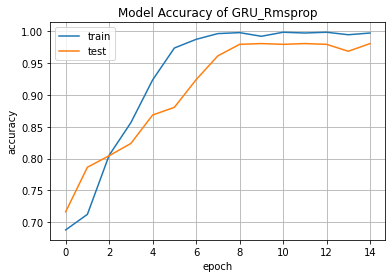

<Figure size 432x288 with 0 Axes>

In [44]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy of GRU_Rmsprop')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()
plt.savefig(f"{Visuals}gru-rms-acc-loss.jpeg")

#Confusion Matrix GRU


In [45]:
y_predict  = [1 if o>0.5 else 0 for o in model.predict(x_test_features)]

In [46]:
cf_matrix =confusion_matrix(test_y,y_predict)

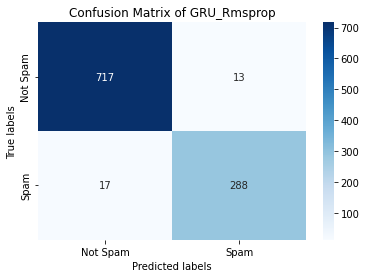

In [47]:
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt='') #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix of GRU_Rmsprop')
ax.xaxis.set_ticklabels(['Not Spam', 'Spam'])
ax.yaxis.set_ticklabels(['Not Spam', 'Spam'])
plt.savefig(f"{heatmaps}gru-rms-heatmap.jpeg")

In [48]:
tn, fp, fn, tp = confusion_matrix(test_y,y_predict).ravel()

In [49]:
print("Precision: {:.2f}%".format(100 * precision_score(test_y, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(test_y, y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(test_y,y_predict)))

Precision: 95.68%
Recall: 94.43%
F1 Score: 95.05%


In [50]:
f1_score(test_y,y_predict)

0.9504950495049506

AUC: 0.9632270379519426


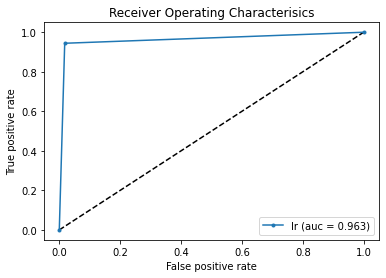

In [51]:
#AUC
auc_gru = ROC_AUC(test_y, y_predict, "gru_rms_AUC.jpeg")

In [52]:
gru = {
    "train-acc" : history.history["accuracy"][len(history.history["accuracy"])-1],
    "test-acc" : accuracy_score(test_y,y_predict),
    "precision" : precision_score(test_y, y_predict),
    "recall" : recall_score(test_y, y_predict),
    "f1-score" : f1_score(test_y,y_predict),
    "AUC" : auc_gru,
    "duration" : duration_gru

}

In [53]:
!ls
model.save("drive/MyDrive/Mahboob/Models/GRU_rms.h5")

drive  sample_data


In [54]:
gru

{'AUC': 0.9632270379519426,
 'duration': 22.07,
 'f1-score': 0.9504950495049506,
 'precision': 0.9568106312292359,
 'recall': 0.9442622950819672,
 'test-acc': 0.9710144927536232,
 'train-acc': 0.9972793459892273}

In [55]:
models_metrics = []
RMS = {
    "lstm-rms" : {
        "train-acc" : 0,
        "test-acc" : 0,
        "precision" : 0,
        "recall" : 0,
        "f1-score" : 0,
        "AUC" : 0,
        "duration" : 0
    },
    "Bi_lstm-rms" : {
        "train-acc" : 0,
        "test-acc" : 0,
        "precision" : 0,
        "recall" : 0,
        "f1-score" : 0,
        "AUC" : 0,
        "duration" : 0
    },
    "gru-rms" : {
        "train-acc" : 0,
        "test-acc" : 0,
        "precision" : 0,
        "recall" : 0,
        "f1-score" : 0,
        "AUC" : 0,
        "duration" : 0
    }
}
for (l,b,g) in zip(lstm,Bi_lstm,gru):
  RMS["lstm-rms"][l] = lstm[l]
  RMS["Bi_lstm-rms"][b] = Bi_lstm[b]
  RMS["gru-rms"][g] = gru[g]   

RMS 



{'Bi_lstm-rms': {'AUC': 0.9666516954861891,
  'duration': 85.54,
  'f1-score': 0.9584026622296173,
  'precision': 0.972972972972973,
  'recall': 0.9442622950819672,
  'test-acc': 0.9758454106280193,
  'train-acc': 0.9981862306594849},
 'gru-rms': {'AUC': 0.9632270379519426,
  'duration': 22.07,
  'f1-score': 0.9504950495049506,
  'precision': 0.9568106312292359,
  'recall': 0.9442622950819672,
  'test-acc': 0.9710144927536232,
  'train-acc': 0.9972793459892273},
 'lstm-rms': {'AUC': 0.9544464406018416,
  'duration': 43.25,
  'f1-score': 0.9252782193958665,
  'precision': 0.8981481481481481,
  'recall': 0.9540983606557377,
  'test-acc': 0.9545893719806763,
  'train-acc': 0.9987908005714417}}

In [56]:
models_metrics= []
for name, model in RMS.items():
  # print(name,model)
  #print(model["y_pred"].shape)
  precision, recall, f1_score_,  = model["precision"], model["recall"], model["f1-score"]
  accuracy, lr_auc = model["test-acc"], model["AUC"]
  Train_acc, duration = model["train-acc"], model["duration"]
  #print(f"precision : {precision} recall : {recall} f1_score : {f1_score_} accuracy : {accuracy}")
  models_metrics.append([name, precision, recall, f1_score_, Train_acc, accuracy, lr_auc, duration])

df_metrics = pd.DataFrame(models_metrics)
df_metrics.columns = ['Model', 'Precision', 'Recall', 'f1 score', "Train Accuracy", 'Test Accuracy', 'ROC-AUC', 'Train Time (s)']
df_metrics.sort_values(by = 'Test Accuracy', ascending = False, inplace=True)
df_metrics.reset_index(drop = True, inplace=True)
df_metrics.to_csv(f"{Comparison}RMS_comparison.csv") 

In [57]:
df_metrics

,Model,Precision,Recall,f1 score,Train Accuracy,Test Accuracy,ROC-AUC,Train Time (s)
0,Bi_lstm-rms,0.972973,0.944262,0.958403,0.998186,0.975845,0.966652,85.54
1,gru-rms,0.956811,0.944262,0.950495,0.997279,0.971014,0.963227,22.07
2,lstm-rms,0.898148,0.954098,0.925278,0.998791,0.954589,0.954446,43.25
